DACON - 영화 관객수 예측 경진대회

https://dacon.io/competitions/open/235536/data

# EDA and Preprocessing
## 사용 라이브러리

In [1]:
pip install xgboost 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

## Data Load 

In [3]:
paths = glob.glob("data/movie/*")
paths

['data/movie\\movies_test.csv',
 'data/movie\\movies_train.csv',
 'data/movie\\submission.csv']

In [4]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [5]:
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

## EDA and preprocessing

### 기본정보

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [7]:
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [9]:
pd.options.display.float_format = '{:.2f}'.format
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


### 결측치 확인

In [10]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [11]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

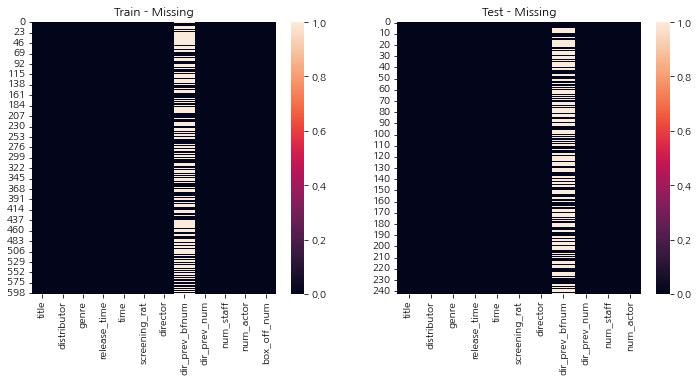

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
sns.heatmap(data = train.isnull(), ax = axes[0]).set_title("Train - Missing")
sns.heatmap(data = test.isnull(), ax = axes[1]).set_title("Test - Missing");

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수로 해당 변수에 결측치가 존재함

관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

### distributor: 배급사

In [13]:
train["distributor"] = train["distributor"].str.replace("\(|주|\)", "")
test["distributor"] = test["distributor"].str.replace("\(|주|\)", "")

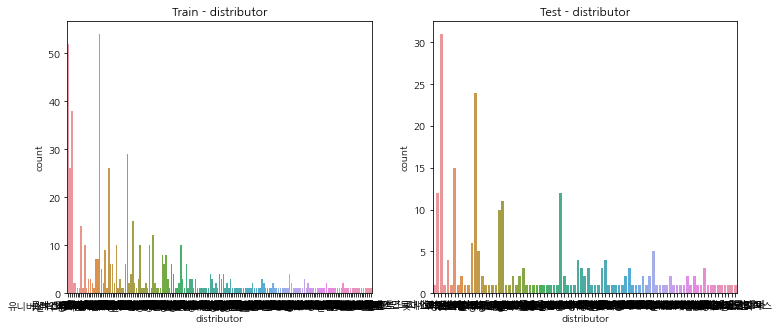

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
sns.countplot(data = train, x = "distributor",ax = axes[0]).set_title("Train - distributor")
sns.countplot(data = test, x = "distributor", ax = axes[1]).set_title("Test - distributor");

In [15]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

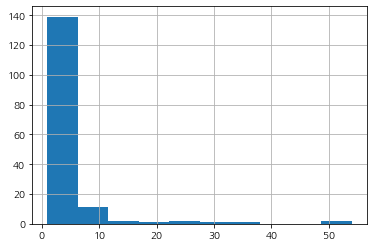

In [16]:
_ = train["distributor"].value_counts().hist()

In [17]:
test["distributor"].unique()

array(['시네마서비스', '쇼박스', 'CJ엔터테인먼트', '모쿠슈라', '시네마달', '루믹스미디어', '마운틴픽쳐스',
       '롯데쇼핑롯데엔터테인먼트', '싸이더스', '시너지', '노근리프로덕션', 'KTG상상마당', '롯데엔터테인먼트',
       '키노아이', '쇼박스미디어플렉스', '리얼라이즈픽쳐스', '스폰지이엔티', '위드시네마', '청년필름', 'NEW',
       '인디스토리', '리아코어콘텐츠', '스토리셋', '영화사조제', '씨네굿필름', '영화사진진', '어뮤즈',
       '핑크로봇필름', 'CinemaSAM', '필라멘트픽쳐스', '갑종필름', '필마픽쳐스', '크리에이티브컴즈',
       'CJEMPictures', '오픈유컬쳐', '웃기씨네', '드림웨스트픽쳐스', '골든타이드픽처스',
       '액티버스엔터테인먼트', '씨너스엔터테인먼트', 'SBS콘텐츠허브', '타임스토리그룹', '팝엔터테인먼트',
       '미로비젼', '나이너스엔터테인먼트', '명필름', '두타연', '영화제작전원사', '무비꼴라쥬', '인벤트디',
       '프리비젼', '미디어데이', '굿픽처스', '레몬트리', '타임스토리', '노바엔터테인먼트', '인디플러그',
       '영화사빅', '유나이티드픽처스', '유영화사화수분', 'BoXoo엔터테인먼트', '늘푸른시네마', '디씨드',
       '케이알씨지', '노버스엔터테인먼트', '드림로드', '씨네그루키다리이엔티', '루스이소니도스', '에이원엔터테인먼트',
       '애니메이션배급', '마인스엔터테인먼트', '이십세기폭스코리아', '트리필름', 'CGV아트하우스', '와우픽쳐스',
       '하준사', '오퍼스픽쳐스', '메가박스중앙플러스엠', '리틀빅픽처스', '미디어로그', '메가박스플러스엠',
       '엣나인필름', '예지림엔터테인먼트', '비에이치제이시네마', '스톰픽쳐스코리아', '다세포클럽', '컨텐츠온미디어',
       '씨

In [24]:
test["distributor"].value_counts().sort_values(ascending=False).nlargest(20)

CJ엔터테인먼트      31
롯데엔터테인먼트      24
마운틴픽쳐스        15
골든타이드픽처스      12
쇼박스           12
인디스토리         11
NEW           10
시네마달           7
KTG상상마당        6
케이알씨지          5
키노아이           5
인벤트디           4
팝엔터테인먼트        4
리틀빅픽처스         3
나이너스엔터테인먼트     3
무비꼴라쥬          3
인디플러그          3
어뮤즈            3
CGV아트하우스       2
싸이더스           2
Name: distributor, dtype: int64

In [ ]:
# value_counts()를 확인해봤을 때 31 + 24 = 55이므로 이론상 중대형이 55가 나오는 것이 맞다..

In [25]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다

def distributor_band(df):
    df["distributor_2"] = df["distributor"]
    big = df["distributor_2"].value_counts() > 15
    big = big[big == True].index.to_list()
    df["distributor"] = df["distributor"].replace(big, "중대형")
    
    small = df["distributor_2"].value_counts() <= 15
    small = small[small == True].index.to_list()
    df["distributor"] = df["distributor"].replace(small, "소형")

In [26]:
distributor_band(train)
train["distributor"].value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [27]:
distributor_band(test)
test["distributor"].value_counts()

소형     188
중대형     55
Name: distributor, dtype: int64

In [28]:
train = train.drop(columns = ["distributor_2"])
test = test.drop(columns = ["distributor_2"])

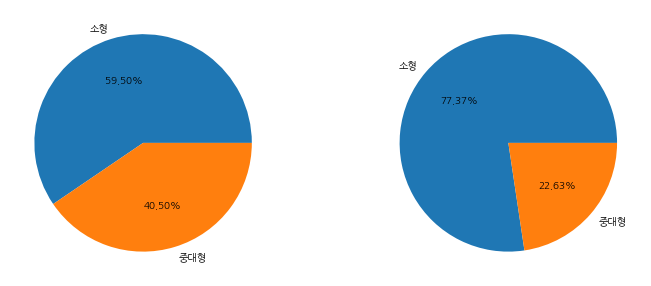

In [29]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

### genre: 장르

In [30]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬         6627.00
다큐멘터리      67172.26
서스펜스       82611.00
애니메이션     181926.67
멜로/로맨스    425968.04
미스터리      527548.18
공포        590832.52
드라마       625689.79
코미디      1193914.00
SF       1788345.69
액션       2203974.07
느와르      2263695.11
Name: box_off_num, dtype: float64

In [31]:
train["genre"].nunique()

12

In [32]:
rank = {"뮤지컬" : 1, "다큐멘터리" : 2, "서스펜스" : 3, "애니메이션" : 4,
        "멜로/로맨스" : 5, "미스터리" : 6, "공포" : 7, "드라마" : 8,
        "코미디" : 9, "SF" : 10, "액션" : 11, "느와르" : 12 }

In [33]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [34]:
train[["genre","rank_genre"]]

,genre,rank_genre
0,액션,11
1,느와르,12
2,액션,11
3,코미디,9
4,코미디,9
...,...,...
595,드라마,8
596,드라마,8
597,공포,7
598,느와르,12


In [35]:
train = train.drop(columns = "genre")
test = test.drop(columns = "genre")

In [36]:
train.shape
test.shape

(243, 11)

### release_time: 개봉일 

In [37]:
train["release_time"] = pd.to_datetime(train["release_time"])
test["release_time"] = pd.to_datetime(test["release_time"])

In [38]:
train["year"] = train["release_time"].dt.year
train["month"] = train["release_time"].dt.month
train["day"] = train["release_time"].dt.day
train["dayofweek"] = train["release_time"].dt.dayofweek

In [39]:
test["year"] = test["release_time"].dt.year
test["month"] = test["release_time"].dt.month
test["day"] = test["release_time"].dt.day
test["dayofweek"] = test["release_time"].dt.dayofweek

In [40]:
train = train.drop(columns = "release_time")
test = test.drop(columns = "release_time")

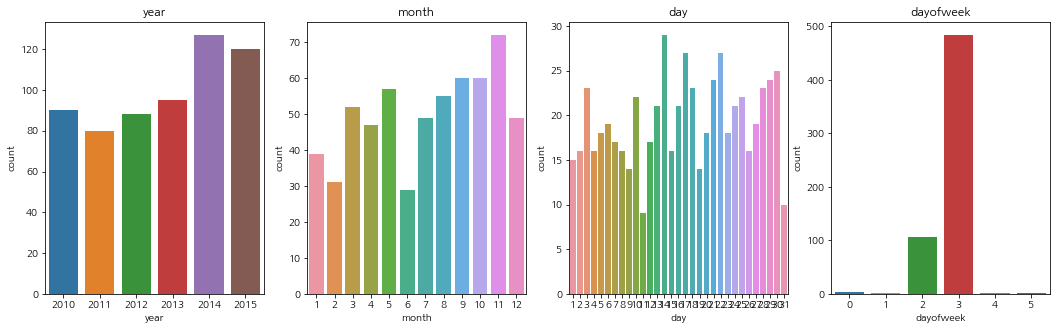

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18,5))
sns.countplot(data = train, x = "year",ax = axes[0]).set_title("year")
sns.countplot(data = train, x = "month",ax = axes[1]).set_title("month")
sns.countplot(data = train, x = "day",ax = axes[2]).set_title("day")
sns.countplot(data = train, x = "dayofweek",ax = axes[3]).set_title("dayofweek");


수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

### Train

In [42]:
train = train.drop(columns = ["title", "director"])

In [43]:
test = test.drop(columns = ["title", "director"])

In [44]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [45]:
train = pd.get_dummies(data = train)
test = pd.get_dummies(data = test)

print(train.shape)
print(test.shape)

(600, 17)
(243, 16)


In [46]:
train.columns

Index(['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'box_off_num', 'rank_genre', 'year', 'month', 'day', 'dayofweek',
       'distributor_소형', 'distributor_중대형', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가'],
      dtype='object')

In [47]:
label_name = "box_off_num"
feature_names = ['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
                 'rank_genre', 'year', 'month', 'day', 'dayofweek',
                 'distributor_소형', 'distributor_중대형', 'screening_rat_12세 관람가',
                 'screening_rat_15세 관람가', 'screening_rat_전체 관람가', 'screening_rat_청소년 관람불가']

### Log scale

In [48]:
train["box_off_num"] = np.log(train["box_off_num"] + 1)

In [49]:
X_train, X_val, y_train, y_val = train_test_split(train[feature_names], train[label_name], test_size=0.15)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [50]:
test.shape

(243, 16)

## Random Forest

In [51]:
model_RF = RandomForestRegressor(random_state= 42,n_jobs = -1)
y_predict_RF = model_RF.fit(X_train, y_train).predict(X_val)

In [52]:
mean_squared_error(y_val, y_predict_RF) ** 0.5

2.1551899340120433

<AxesSubplot:>

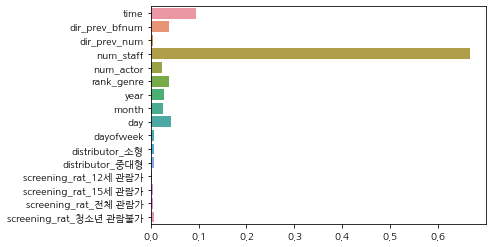

In [53]:
sns.barplot(x=model_RF.feature_importances_, y = model_RF.feature_names_in_)

## XGBoost

In [54]:
model_XG = XGBRegressor(random_state= 42,n_jobs = -1)
y_predict_XG = model_XG.fit(X_train, y_train).predict(X_val)

In [55]:
mean_squared_error(y_val, y_predict_XG) ** 0.5

2.105466370574306

<AxesSubplot:>

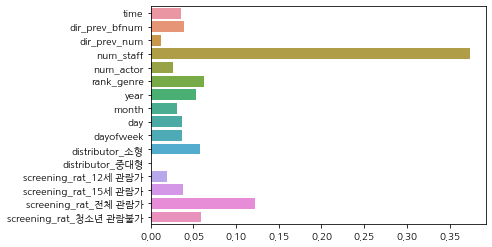

In [56]:
sns.barplot(x=model_XG.feature_importances_, y = model_XG.feature_names_in_)

## LightGBM

In [57]:
model_BM = LGBMRegressor(random_state= 42,n_jobs = -1)
y_predict_BM = model_BM.fit(X_train, y_train).predict(X_val)

In [58]:
mean_squared_error(y_val, y_predict_BM) ** 0.5

2.2411009253003873

<AxesSubplot:>

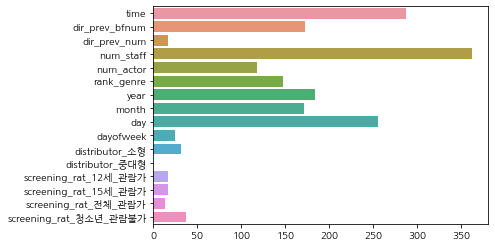

In [59]:
sns.barplot(x=model_BM.feature_importances_, y = model_BM.feature_name_)